In [1]:
# Clones repository, installs dsf, and downloads full json files (~9Gb), installs dependecies assuming pip is being used
# !git clone https://github.com/NAIST-SE/DevGPT/tree/main
# !git dsf install
# !git dsf pull
#!pip install pandas numpy matplotlib torch torchtext nltk scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, json
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Directory that snapshots are stored in
DATA_DIRECTORY = 'DevGPT'

In [3]:
df = pd.DataFrame()

# for each snapshot
for directory in os.listdir(DATA_DIRECTORY):
    snapshot_directory = os.path.join(DATA_DIRECTORY, directory)

    # Is this a file or a directory?
    if os.path.isdir(snapshot_directory):

        # find json file names within directory
        json_files = []
        for file in os.listdir(snapshot_directory):
            if file.endswith('.json'):
                json_files.append(file)

        # for each json file in snapshot
        for json_file in json_files:
            json_file_path = os.path.join(snapshot_directory, json_file)
            
            # read json file
            with open(json_file_path, 'r', encoding='utf-8') as file:
                json_data = json.load(file)
            
            # create features for objects within "ChatgptSharing"
            json_df = pd.json_normalize(json_data['Sources'][0]['ChatgptSharing'])

            # add to dataframe
            df = pd.concat([df, json_df])


# easy exploring of question 1
prompts = ''
for conversation in df['Conversations']:
    for prompt_answer_pairs in conversation:
            prompts += ' ' + prompt_answer_pairs['Prompt']
            
len(prompts)

# "words" to exclude based on me running this initially
excluded_words = set(['0|mindful', 'from', 'your'])

# Take prompts with stop word filtered and display the 20 most common
filtered_prompts = [word.lower() for word in prompts.split() if (word.lower() not in excluded_words) and (len(word) > 4)]
c = Counter(filtered_prompts) 
most_common = c.most_common(20) 
  
print(most_common)



[('break', 3707), ('const', 234), ('student', 187), ('<li><a', 168), ('import', 147), ('environment>', 144), ('function', 139), ('none;', 137), ('display:', 136), ('20px;', 127), ('photoelectric', 112), ('padding:', 106), ('.container', 105), ('create', 96), ('<sep>', 88), ('using', 85), ('inherit;', 84), ('margin:', 84), ('energy', 80), ('[begin]', 80)]


In [4]:
# Prepareing Data for Question 7

df = pd.DataFrame()
temo_df = pd.DataFrame()

# for each snapshot
for directory in os.listdir(DATA_DIRECTORY):
    snapshot_directory = os.path.join(DATA_DIRECTORY, directory)


    # Is this a file or a directory?
    if os.path.isdir(snapshot_directory):

        # find json file names within directory
        json_files = []
        for file in os.listdir(snapshot_directory):
            if file.endswith('.json'):
                json_files.append(file)

        # for each json file in snapshot
        for json_file in json_files:
            json_file_path = os.path.join(snapshot_directory, json_file)
            conversation_lengths, conversation_prompts = [],[]
            temp_df = pd.DataFrame()
            
            # load json file
            with open(json_file_path, 'r', encoding='utf-8') as file:
                json_data = json.load(file)
            
            # gather conversations the get length and initial prompt to load into dataframe
            for i in range(len(json_data['Sources'])):
                if 'Conversations' in json_data['Sources'][i]['ChatgptSharing'][0]:
                    conversations = json_data['Sources'][i]['ChatgptSharing'][0]['Conversations']
                    conversation_lengths.append(len(conversations))
                    conversation_prompts.append(conversations[0]['Prompt'])

            temp_df['Conversation Length'] = conversation_lengths
            temp_df['Prompt'] = conversation_prompts
            df = pd.concat([df, temp_df], axis=0, ignore_index=True)

# shuffle dataframe
df = df.sample(frac=1)          

Text(0, 0.5, 'Prompt Length')

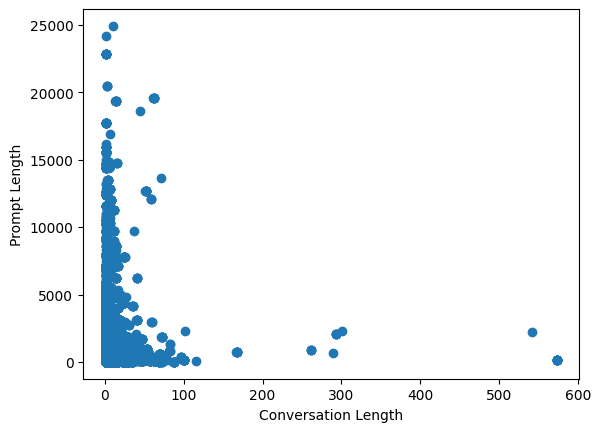

In [5]:
# Create new column for prompt character length
df['Prompt Length'] = df['Prompt'].apply(len)
lengths = []
for index, prompt in df.iterrows():
    lengths.append(len(prompt['Prompt']))


plt.scatter(df["Conversation Length"], df['Prompt Length'])

plt.xlabel("Conversation Length")
plt.ylabel("Prompt Length")

In [6]:
# My attempt at the model
class NLP_Model(nn.Module):
    def __init__(self, vocabulary_size, hidden_layer_dimension, maximum_imbedding_length):
        super(NLP_Model, self).__init__()
        self.embedding = nn.Embedding(vocabulary_size, 5, padding_idx=0)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(maximum_imbedding_length * 5, hidden_layer_dimension),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.fc(x)
        return x

In [10]:
# using numpy - attempt to tokenize failed due to memory contraints

# get all characters in the dataset
all_chars = "".join(df['Prompt'].values)

# find all unique characters
unique_chars = np.unique(list(all_chars).sort())

char_to_index = np.zeros(256, dtype=int)
# map character codes to indicies
char_to_index[unique_chars] = np.arange(len(unique_chars)) 

# max prompt length
max_length = max(len(text) for text in df['Prompt'])

# creat numpy array initializing with zeros for padding
encoded_texts = np.zeros((len(df), max_length), dtype=int)

# for each prompt, encode characters using numpy vectorized operations
for i, text in enumerate(df['Prompt']):
    char_indices = np.array([char_to_index[ord(char)] for char in text], dtype=int)
    encoded_texts[i, :len(char_indices)] = char_indices



IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
# convert dataframe columns to tensors
X = torch.tensor(df['Prompt'].values)
y = torch.tensor(df['Conversation Length'].values)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# hyperparameters
vocab_size = len(char_to_index)
embed_dim = 8
hidden_dim = 16
model = Model(vocab_size, embed_dim, hidden_dim)

# loss and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = loss_function(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# error evaluation
model.eval()
predictions = model(X_test).squeeze()
mse = loss_function(predictions, y_test)
print(f"Test MSE: {mse.item()}")